EXPLICACION UNO: Se lee el archivo con pd.read_csv()
Si hay valores no numéricos o nulos en “Tiempo/Calificación”, se eliminan para evitar errores de cálculo.
Después apliqué el rango intercuartil (IQR) para calcular Q1 y Q3 y marcar como atípicos los valores que queden demasiado lejos de ese rango.
Filtrar estos valores extremos es importante porque los outliers pueden influir de manera desproporcionada en los coeficientes de regresión y aumentar artificialmente el error.
Después de limpiar, se genera una gráfica de dispersión de Tiempo vs Calificación para observar la forma de la relación.

Con este gráfico podemos decir que la relación no parece lineal, por lo que modelos no lineales (polinomial de bajo grado, segmentado o KNN) pueden capturar mejor la tendencia.

Datos luego de eliminar los outliers: 424


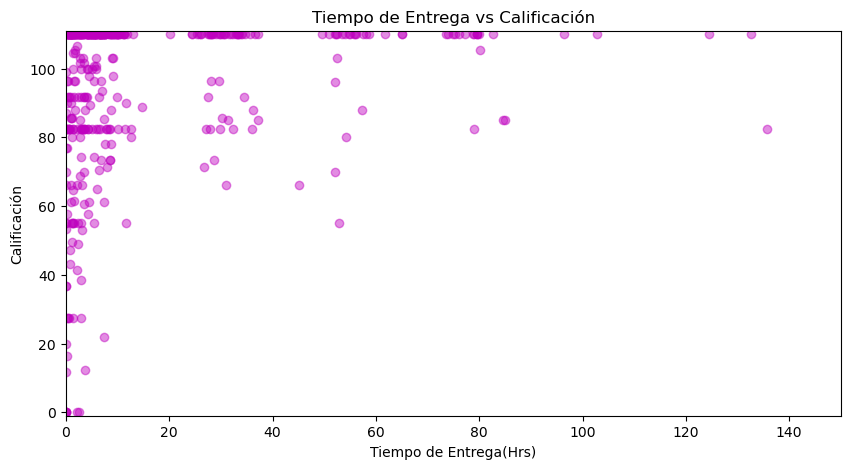

In [118]:
!pip install mlinsights
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

df=pd.read_csv("TiempodeEntrega.csv")
df.head()

Q1=df.Tiempo.quantile(0.25)
Q3=df.Tiempo.quantile(0.75)
IQR=Q3-Q1
li = Q1-(3*IQR)
ls = Q3+(3*IQR)
out = df[(df.Tiempo<=li) | (df.Tiempo>=ls)]

minout = out.Tiempo.min()
maxout = out.Tiempo.max()

df_cleaned = df[~df.Tiempo.isin([minout, maxout])]
print(f"Datos luego de eliminar los outliers: {len(df_cleaned)}")

plt.figure(figsize=(10, 5))
plt.scatter(df_cleaned['Tiempo'],df_cleaned['Calificacion'],color='m',alpha=0.45)
plt.xlim(0, 150)
plt.ylim(df_cleaned['Calificacion'].min()-1, df_cleaned['Calificacion'].max()+1)
plt.title('Tiempo de Entrega vs Calificación')
plt.xlabel('Tiempo de Entrega(Hrs)')
plt.ylabel('Calificación')
plt.show()


EXPLICACION DOS:El conjunto de datos se divide en 70% entrenamiento y 30% prueba para separar el aprendizaje del modelo de su evaluación, reduciendo el riesgo de sobreajuste.
Se calculan los promedios de tiempo y calificación en los conjuntos de entrenamiento y prueba para comprobar si ambos mantienen una distribución semejante, cuando las medias son cercanas, el conjunto de prueba representa bien a los datos con los que se entrenó el modelo. 
Si hay diferencias grandes, la prueba puede no ser confiable porque estaría evaluando el desempeño con características distintas.

In [119]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df_cleaned[['Tiempo']],df_cleaned['Calificacion'],test_size=0.3,random_state=42)
print("Promedio de horas en ENTRENAMIENTO:")
print("", Xtrain.mean())
print("Promedios de horas en PRUEBA:")
print("", Xtest.mean())

print("\nPromedio de calificación en ENTRENAMIENTO:")
print("Calificación:", ytrain.mean())
print("Promedios de calificación en PRUEBA:")
print("Calificación:", ytest.mean())

Promedio de horas en ENTRENAMIENTO:
 Tiempo    17.4102
dtype: float64
Promedios de horas en PRUEBA:
 Tiempo    16.440124
dtype: float64

Promedio de calificación en ENTRENAMIENTO:
Calificación: 94.45757506756757
Promedios de calificación en PRUEBA:
Calificación: 95.915360625


EXPLICACION TRES:El modelo polinomial que usé me permitió capturar la relación curva entre el tiempo de entrega y la calificación.
El resumen estadístico mostró que el coeficiente lineal es 2.43, con un valor p prácticamente cero, lo que significa que la relación es positiva y estadísticamente significativa, es decir, entregar con más horas de anticipación se asocia con calificaciones más altas. Este resultado respalda la teoría de que al acercarse al límite de tiempo las calificaciones tienden a disminuir, y confirma que el tiempo de entrega está fuertemente relacionado con el desempeño obtenido.
El  RSE nos dio 21.4 y la R2 0.125 lo cual puede indicarnos que este modelo no sea la mejor opción para medir.

In [120]:
Xtemp_train = np.array(Xtrain).reshape(-1, 1)
Xtemp_test = np.array(Xtest).reshape(-1, 1)
poly_train = PolynomialFeatures(degree=5).fit(Xtemp_train)
poly_test = PolynomialFeatures(degree=5).fit(Xtemp_test)
X_train = pd.DataFrame(poly_train.transform(Xtemp_train))
X_test = pd.DataFrame(poly_test.transform(Xtemp_test))
modelPolinomial = sm.OLS(list(y_train),X_train).fit()
yhat_modelPolinomial = modelPolinomial.predict(X_test)
RSS_modelPolinomial = sum((list(y_test) - yhat_modelPolinomial)**2)
RSE_modelPolinomial = np.sqrt(RSS_modelPolinomial/(len(y_test)-1))
print("RSE con modelo polinomial grado 5: ",RSE_modelPolinomial)
print(modelPolinomial.summary())

RSE con modelo polinomial grado 5:  21.38957560926544
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     8.272
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           2.53e-07
Time:                        23:52:41   Log-Likelihood:                -1352.4
No. Observations:                 296   AIC:                             2717.
Df Residuals:                     290   BIC:                             2739.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

EXPLICACION CUATRO:En lugar de usar un único polinomio ahora dividimos el eje de tiempo en segmentos y ajustamos una cuadrática en cada tramo.
Esto se hace porque un polinomio de grado alto puede oscilar demasiado y sobreajustar, mientras que los tramos permiten capturar cambios locales de tendencia de manera más estable. 
Esta segmentación nos es útil para fenómenos donde la relación no es uniforme en todo el rango de la variable independiente.
Este resultado nos dio más pequeño lo que puede decir que es una mejor forma para el modelo. 

In [121]:
modelPieceWise = PiecewiseRegressor('bins').fit(X_train.iloc[:,1:],y_train)
yhat_modelPiecewise = modelPieceWise.predict(X_test.iloc[:,1:])
RSS_modelPiecewise = sum((list(y_test) - yhat_modelPiecewise)**2)
RSE_modelPiecewise = np.sqrt(RSS_modelPiecewise/(len(y_test)-1))
print("RSE-Piecewise: ",RSE_modelPiecewise)

RSE-Piecewise:  19.92242261157405


EXPLICACION CINCO: Ahora usamos el modelo KNN, que es el modelo de vecinos más cercanos, este estima la calificación de un ejemplo a partir de los valores de sus k vecinos en el conjunto de entrenamiento. 

In [122]:
modelKNN = KNN(n_neighbors=5).fit(Xtemp_train,y_train)
yhat_modelKNN = modelKNN.predict(Xtemp_test)

RSS_modelKNN = sum((list(y_test) - yhat_modelKNN)**2)
RSE_modelKNN = np.sqrt(RSS_modelKNN/(len(y_test)-1))
print("RSE-KNN: ",RSE_modelKNN)

RSE-KNN:  22.42031978948202


EXPLICACION SEIS: Analizando ya los valores de RSE para todos los modelos, podemos concluir que el "mejor modelo" es el de Piecewise, claro está que necesitamos considerar más parámetros, pues esta variable tiende a variar mucho, en especial si queremos hacerlo mas específico o a profundidad.

In [123]:
print("RSE-Modelo polinomial grado 5: ",RSE_modelPolinomial)
print("RSE-Piecewise: ",RSE_modelPiecewise)
print("RSE-KNN: ",RSE_modelKNN)

RSE-Modelo polinomial grado 5:  21.38957560926544
RSE-Piecewise:  19.92242261157405
RSE-KNN:  22.42031978948202


EXPLICACION SIETE: Por ultimo graficamos el modelo y con diferentes colores comparamos para cada una de las predicciones.

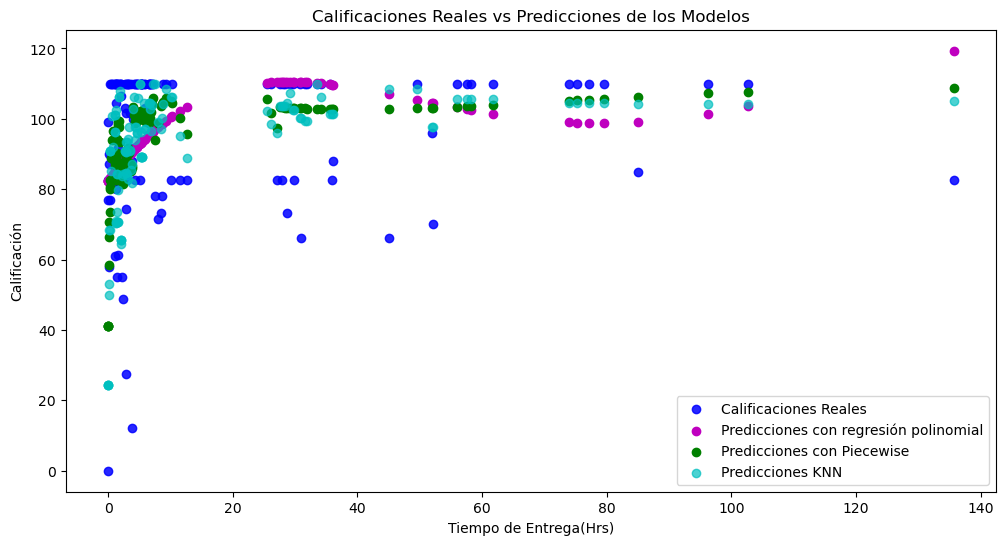

In [124]:
plt.figure(figsize=(12, 6))
plt.scatter(Xtest, ytest, color='b', label='Calificaciones Reales', alpha=0.85)

plt.scatter(Xtest, yhat_modelPolinomial, color='m', label='Predicciones con regresión polinomial')
plt.scatter(Xtest, yhat_modelPiecewise, color='g', label='Predicciones con Piecewise')
plt.scatter(Xtest, yhat_modelKNN, color='c', label='Predicciones KNN', alpha=0.7)

plt.xlabel('Tiempo de Entrega(Hrs)')
plt.ylabel('Calificación')
plt.title('Calificaciones Reales vs Predicciones de los Modelos')
plt.legend()
plt.show()